In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import numpy as np
import os
from sympy import *

from scipy import *
from scipy import integrate
from scipy.integrate import ode

from jupyter_client.manager import KernelManager
from ipykernel import kernelapp as app



In [2]:
#Importa Parametros de control

f = open ('parrov_bluerov.txt','r')
D={}
for i in f:
    [clave, valor]= i.split("=")
    D[clave] = float(valor[:-2])
f.close()
#Se asignan las variables... esto se hace para que sea sencillo describir mas adelante las matrices .... Ya estan los C+ y C- ??
[m,xg,yg,zg,xb,yb,zb,Ix,Iy,Iz,Ixy,Ixz,Iyz,W,B,Xu,Yv,Zw,Kp,Mq,Nr,Xudot,Yvdot,Zwdot,Kpdot,Mqdot,Nrdot,Xuu,Yvv,Zww,Kpp,Mqq,Nrr,lx1,ly1,lz1,lx2,ly2,lz2,lx3,ly3,lz3,lx4,ly4,lz4,lx5,ly5,lz5,lx6,ly6,lz6,Cmas1,Cmas2,Cmas3,Cmas4,Cmas5,Cmas6,Cmenos1,Cmenos2,Cmenos3,Cmenos4,Cmenos5,Cmenos6 ]   =   [D['m'],D['xg'],D['yg'],D['zg'],D['xb'],D['yb'],D['zb'],D['Ix'],D['Iy'],D['Iz'],D['Ixy'],D['Ixz'],D['Iyz'],D['W'],D['B'],D['Xu'],D['Yv'],D['Zw'],D['Kp'],D['Mq'],D['Nr'],D['Xudot'],D['Yvdot'],D['Zwdot'],D['Kpdot'],D['Mqdot'],D['Nrdot'],D['Xuu'],D['Yvv'],D['Zww'],D['Kpp'],D['Mqq'],D['Nrr'],D['lx1'],D['ly1'],D['lz1'],D['lx2'],D['ly2'],D['lz2'],D['lx3'],D['ly3'],D['lz3'],D['lx4'],D['ly4'],D['lz4'],D['lx5'],D['ly5'],D['lz5'],D['lx6'],D['ly6'],D['lz6'],0.000333,0.000333,0.000224,0.000241,0.000241,0.000243,0.000368,0.000368,0.000227,0.000175,0.000175,0.000229]




In [3]:
#Se crean las variables simbolicas dependientes e independientes

#Entradas para el modelo dinamico .... Torques aplicados por los propulsores
u1 = symbols('u1')
u2 = symbols('u2')
u3 = symbols('u3')
u4 = symbols('u4')
u5 = symbols('u5')
u6 = symbols('u6')
U= np.array([u1,u2,u3,u4,u5,u6]) # Se define el vector de entradas

#Salidas de mi modelo dinamico... o velocidades en el marco de referencia local
u = symbols('u')
v = symbols('v')
w = symbols('w')
p = symbols('p')
q = symbols('q')
r = symbols('r')
V = np.array([u,v,w,p,q,r])
t = symbols("t") #Tiempo

#Salidas de posiciones lineales y angulares del marco de referencia inercial en funcion a las velocidades del marco local
x = symbols('x')
y = symbols('y')
z = symbols('z')
theta = symbols('theta')
phi = symbols('phi')
psi = symbols('psi')
n = np.array([x,y,z,phi,theta,psi])

U= np.array([symbols('u1'), symbols('u2'), symbols('u3'), symbols('u4'), symbols('u5'), symbols('u6')]) # Se define el vector de entradas
V = np.array([symbols('u'),symbols('v'),symbols('w'),symbols('p'),symbols('q'),symbols('r')])
n = np.array([symbols('x'),symbols('y'),symbols('z'),symbols('phi'),symbols('theta'),symbols('psi')])

In [4]:
#Se construye la matriz J1 y J2 y finalmente J2
from sympy import *

J1 = np.array([[cos(theta)*cos(psi),(-cos(phi)*sin(psi))+(sin(phi)*sin(theta)*cos(psi)), (sin(phi)*sin(psi))+ (cos(phi)*sin(theta)*cos(psi))],
               [cos(theta)*sin(psi),(cos(phi)*cos(psi))+(sin(phi)*sin(theta)*sin(psi)) ,(-sin(phi)*cos(psi))+ (cos(phi)*sin(theta)*sin(psi))],
               [   -sin(theta)     ,            cos(theta)*sin(phi)                    ,                   cos(theta)*cos(phi)              ]])
J2 = np.array([[     1.0     ,  sin(phi)*sin(theta)/cos(theta)  ,  cos(phi)*sin(theta)/cos(theta)  ],
               [     0.0     ,             cos(phi)             ,            -sin(phi)             ],
               [     0.0     ,        sin(phi)/cos(theta)       ,               1.0                ]])
zeros = np.zeros((3,3))
J = np.concatenate((np.concatenate((J1, zeros), axis=1), np.concatenate((zeros, J2), axis=1)), axis=0)
print("J1 = \n{}".format(J1))
print("J2 = \n{}".format(J2))
print("J = \n{}".format(J))



J1 = 
[[cos(psi)*cos(theta) sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)
  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)]
 [sin(psi)*cos(theta) sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)
  -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)]
 [-sin(theta) sin(phi)*cos(theta) cos(phi)*cos(theta)]]
J2 = 
[[1.0 sin(phi)*sin(theta)/cos(theta) sin(theta)*cos(phi)/cos(theta)]
 [0.0 cos(phi) -sin(phi)]
 [0.0 sin(phi)/cos(theta) 1.0]]
J = 
[[cos(psi)*cos(theta) sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)
  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi) 0.0 0.0 0.0]
 [sin(psi)*cos(theta) sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)
  -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi) 0.0 0.0 0.0]
 [-sin(theta) sin(phi)*cos(theta) cos(phi)*cos(theta) 0.0 0.0 0.0]
 [0.0 0.0 0.0 1.0 sin(phi)*sin(theta)/cos(theta)
  sin(theta)*cos(phi)/cos(theta)]
 [0.0 0.0 0.0 0.0 cos(phi) -sin(phi)]
 [0.0 0.0 0.0 0.0 sin(phi)/cos(theta) 1.0]]


In [5]:
#Vector de fuerza gravitacional y de empuje
from sympy import *

g = [                         (W-B)*sin(theta)                             ,    
                         -(W-B)*cos(theta)*sin(phi)                        ,    
                         -(W-B)*cos(theta)*cos(phi)                        ,     
     -((yg*W)-(yb*B))*cos(theta)*cos(phi) + (zg*W-zb*B)*cos(theta)*sin(phi),
           ((zg*W)-(zb*B))*sin(theta) + (xg*W-xb*B)*cos(theta)*cos(phi)   ,
       -((xg*W)-(xb*B))*cos(theta)*sin(phi) - (yg*W-yb*B)*sin(theta)       ]
print(g)



[-6.67*sin(theta), 6.67*sin(phi)*cos(theta), 6.67*cos(phi)*cos(theta), -0.0148922*sin(phi)*cos(theta), -0.0148922*sin(theta), 0]


In [6]:
#Matriz M
#Matriz M_RB                     
M_RB = np.array([[     m        ,        0      ,        0      ,      0        ,     m*zg     ,       -m*yg    ],
                 [     0        ,        m      ,        0      ,    -m*zg      ,       0      ,        m*xg    ],
                 [     0        ,        0      ,        m      ,     m*yg      ,    -m*xg     ,          0     ],
                 [     0        ,      -m*zg    ,       m*yg    ,      Ix       ,    -Ixy      ,        -Ixz    ],
                 [    m*zg      ,        0      ,      -m*xg    ,     -Ixy      ,     Iy       ,        -Iyz    ],
                 [   -m*yg      ,       m*xg    ,        0      ,     -Ixz      ,     -Iyz     ,         Iz     ]])
#Matriz M_A
M_A = -np.array([Xudot,Yvdot,Zwdot,Kpdot,Mqdot,Nrdot]) * np.eye(6) # MUltiplica vector valores con matris identidad 6x6

M= M_RB + M_A

print("M_RB = \n{}".format(M_RB))
print("M_A = \n{}".format(M_A))
print("M = \n{}".format(M))



M_RB = 
[[ 7.31  0.    0.    0.    0.   -0.  ]
 [ 0.    7.31  0.   -0.    0.    0.  ]
 [ 0.    0.    7.31  0.   -0.    0.  ]
 [ 0.   -0.    0.    0.16 -0.   -0.  ]
 [ 0.    0.   -0.   -0.    0.16 -0.  ]
 [-0.    0.    0.   -0.   -0.    0.16]]
M_A = 
[[ 5.5   0.    0.    0.    0.    0.  ]
 [ 0.   12.7   0.    0.    0.    0.  ]
 [ 0.    0.   14.57  0.    0.    0.  ]
 [ 0.    0.    0.    0.12  0.    0.  ]
 [ 0.    0.    0.    0.    0.12  0.  ]
 [ 0.    0.    0.    0.    0.    0.12]]
M = 
[[12.81  0.    0.    0.    0.    0.  ]
 [ 0.   20.01  0.    0.    0.    0.  ]
 [ 0.    0.   21.88  0.    0.    0.  ]
 [ 0.    0.    0.    0.28  0.    0.  ]
 [ 0.    0.    0.    0.    0.28  0.  ]
 [ 0.    0.    0.    0.    0.    0.28]]


In [7]:
#Matriz C.... Matriz de fuerzas centrípeta y Coriolis
#Matriz C_RB
#Matriz C12 
C11 = np.eye(3)*0 #Crea matriz 3x3 de Ceros
C12 = np.array([[ m*(yg*q +zg*r), -m*(xg*q-w)  , -m*(xg*r+v)  ],
                [ -m*(yg*p+w)   , m*(zg*r+xg*p), -m*(yg*r-u)  ],
                [ -m*(zg*p-v)   , -m*(zg*q+u)  , m*(xg*p+yg*q)]])

C22 = np.array([[         0                 ,-Iyz*q-Ixz*p+Iz*r, Iyz*r+Ixy*p-Iy*q],
                [ Iyz*q+Ixz*p-Iz*r,          0               ,-Ixz*r-Ixy*q+Ix*p],
                [-Iyz*r-Ixy*p+Iy*q , Ixz*r+Ixy*q-Ix*p, 0                  ]])
C21 = -np.transpose(C12) # Transpuesta de C12
C_RB = np.concatenate((np.concatenate((C11, C12), axis=1), np.concatenate((C21, C22), axis=1)), axis=0)



CA = np.array([[     0        ,        0      ,        0      ,      0        , -Zwdot*w  ,     Yvdot*v ],
               [     0        ,        0      ,        0      ,   Zwdot*w     ,     0     ,    -Xudot*u ],
               [     0        ,        0      ,        0      ,  -Yvdot*v     ,  Xudot*u  ,       0     ],
               [     0        ,    -Zwdot*w   ,      Yvdot*v  ,      0        , -Nrdot*r  ,     Mqdot*q ],
               [   Zwdot*w    ,        0      ,    -Xudot*u   ,  Nrdot*r      ,     0     ,   -Kpdot*p ],
               [  -Yvdot*v    ,    Xudot*u    ,        0      , -Mqdot*q      ,  Kpdot*p  ,          0     ]])
 
C = C_RB + CA
print("C_RB = \n{}".format(C_RB))
print("CA = \n{}".format(CA))
print("C = \n{}".format(C))


C_RB = 
[[0.0 0.0 0.0 0 7.31*w -7.31*v]
 [0.0 0.0 0.0 -7.31*w 0 7.31*u]
 [0.0 0.0 0.0 7.31*v -7.31*u 0]
 [0 7.31*w -7.31*v 0 0.16*r -0.16*q]
 [-7.31*w 0 7.31*u -0.16*r 0 0.16*p]
 [7.31*v -7.31*u 0 0.16*q -0.16*p 0]]
CA = 
[[0 0 0 0 14.57*w -12.7*v]
 [0 0 0 -14.57*w 0 5.5*u]
 [0 0 0 12.7*v -5.5*u 0]
 [0 14.57*w -12.7*v 0 0.12*r -0.12*q]
 [-14.57*w 0 5.5*u -0.12*r 0 0.12*p]
 [12.7*v -5.5*u 0 0.12*q -0.12*p 0]]
C = 
[[0.0 0.0 0.0 0 21.88*w -20.01*v]
 [0.0 0.0 0.0 -21.88*w 0 12.81*u]
 [0.0 0.0 0.0 20.01*v -12.81*u 0]
 [0 21.88*w -20.01*v 0 0.28*r -0.28*q]
 [-21.88*w 0 12.81*u -0.28*r 0 0.28*p]
 [20.01*v -12.81*u 0 0.28*q -0.28*p 0]]


In [8]:
#Matriz de amortiguamiento hidrodinamico
DL = -1 *np.array([Xu,Yv,Zw,Kp,Mq,Nr]) * np.eye(6)
DQ = -1 *np.array([Xuu*Abs(u),Yvv*Abs(v),Zww*Abs(w),Kpp*Abs(p),Mqq*Abs(q),Nrr*Abs(r)]) * np.eye(6)
D = DL + DQ
print("DL = \n{}".format(DL))
print("DQ = \n{}".format(DQ))


DL = 
[[4.03 0.   0.   0.   0.   0.  ]
 [0.   6.22 0.   0.   0.   0.  ]
 [0.   0.   5.18 0.   0.   0.  ]
 [0.   0.   0.   0.07 0.   0.  ]
 [0.   0.   0.   0.   0.07 0.  ]
 [0.   0.   0.   0.   0.   0.07]]
DQ = 
[[18.18*Abs(u) 0 0 0 0 0]
 [0 21.66*Abs(v) 0 0 0 0]
 [0 0 36.99*Abs(w) 0 0 0]
 [0 0 0 1.55*Abs(p) 0 0]
 [0 0 0 0 1.55*Abs(q) 0]
 [0 0 0 0 0 1.55*Abs(r)]]


In [9]:
#Matriz de configuracion de los propulsores T
T= np.array([[     0        ,        0      ,        0      ,      1        ,       1     ,          0      ],
             [     0        ,        0      ,        0      ,      0        ,       0     ,          1      ],
             [    -1        ,        -1     ,        -1     ,      0        ,       0     ,          0      ],
             [   -ly1       ,      -ly2     ,      -ly3     ,      0        ,       0     ,        -lz6     ],
             [    lx1       ,        lx2    ,       lx3     ,     lz4       ,      lz5    ,          0      ],
             [     0        ,        0      ,        0      ,    -ly4       ,     -ly5    ,         lx6     ]])

Cmas = np.array([Cmas1,Cmas2,Cmas3,Cmas4,Cmas5,Cmas6]) * np.eye(6)
Cmenos = np.array([Cmenos1,Cmenos2,Cmenos3,Cmenos4,Cmenos5,Cmenos6]) * np.eye(6)

TCmas = np.dot(T,Cmas)
TCmenos = np.dot(T,Cmenos)

print("T = \n{}".format(T))
print("C+ = \n{}".format(Cmas))
print("TC+ = \n{}".format(TCmas))



T = 
[[ 0.00e+00  0.00e+00  0.00e+00  1.00e+00  1.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00]
 [-1.00e+00 -1.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 1.11e-04 -1.11e-04 -0.00e+00  0.00e+00  0.00e+00 -9.50e-05]
 [ 1.53e-04  1.53e-04 -1.99e-04 -1.40e-05 -1.40e-05  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.11e-04  1.11e-04  8.00e-06]]
C+ = 
[[0.000333 0.       0.       0.       0.       0.      ]
 [0.       0.000333 0.       0.       0.       0.      ]
 [0.       0.       0.000224 0.       0.       0.      ]
 [0.       0.       0.       0.000241 0.       0.      ]
 [0.       0.       0.       0.       0.000241 0.      ]
 [0.       0.       0.       0.       0.       0.000243]]
TC+ = 
[[ 0.0000e+00  0.0000e+00  0.0000e+00  2.4100e-04  2.4100e-04  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  2.4300e-04]
 [-3.3300e-04 -3.3300e-04 -2.2400e-04  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 3.6963e-08 -3.6963e-08  0.0000e+

In [10]:
print(np.dot(np.dot(  np.linalg.inv(M) ,  TCmas) ,U)) #M-1*TC+*V


[1.88134270101483e-5*u4 + 1.88134270101483e-5*u5 1.2143928035982e-5*u6
 -1.52193784277879e-5*u1 - 1.52193784277879e-5*u2 - 1.02376599634369e-5*u3
 1.32010714285714e-7*u1 - 1.32010714285714e-7*u2 - 8.24464285714286e-8*u6
 1.81960714285714e-7*u1 + 1.81960714285714e-7*u2 - 1.592e-7*u3 - 1.205e-8*u4 - 1.205e-8*u5
 -9.55392857142857e-8*u4 + 9.55392857142857e-8*u5 + 6.94285714285714e-9*u6]


In [27]:
#Se replantea la ecuacion diferencial despejando Vdot
# INGRESO
D_ = np.dot(np.dot(  np.linalg.inv(M) ,  D ) ,V)  #M-1*D*V
C_ = np.dot(np.dot(  np.linalg.inv(M) ,  C ) ,V)  #M-1*C*V

TMas_ = np.dot(np.dot(  np.linalg.inv(M) ,  TCmas) ,U) #M-1*TC+*V
TMenos_ = np.dot(np.dot(  np.linalg.inv(M) ,  TCmenos) ,U) #M-1*TC+*V
#print("M = \n{}".format( np.linalg.inv(M)))
#print("C = \n{}".format(C))
#print("V = \n{}".format(V))
print(TMas_)

Vdott = {}
Vdott["CMas"] = -C_ -D_ -np.dot(  np.linalg.inv(M) ,  g)  + TMas_ 
Vdott["CMenos"] = -C_ -D_ -np.dot(  np.linalg.inv(M) ,  g) + TMenos_

print("udot = \n{}\n\n".format(Vdott["CMas"][0]))
print("vdot = \n{}\n\n".format(Vdott["CMas"][1]))
print("wdot = \n{}\n\n".format(Vdott["CMas"][2]))
print("pdot = \n{}\n\n".format(Vdott["CMas"][3]))
print("qdot = \n{}\n\n".format(Vdott["CMas"][4]))
print("rdot = \n{}\n\n".format(Vdott["CMas"][5]))



#Se expresa ndot y de esta forma tenemos nuestro sistema de 12 ecuaciones diferenciales no lineales

ndott = np.dot(J,V) #Vector de velocidad en el marco de referencia
print("xdot = \n{}\n\n".format(ndott[0]))
print("ydot = \n{}\n\n".format(ndott[1]))
print("zdot = \n{}\n\n".format(ndott[2]))
print("phidot = \n{}\n\n".format(ndott[3]))
print("thetadot = \n{}\n\n".format(ndott[4]))
print("psidot = \n{}\n\n".format(ndott[5]))
Modelo_Ecuaciones = "{}\n {}\n {}".format(Vdott["CMas"].tolist(),Vdott["CMenos"].tolist(),ndott.tolist())

f = open ('Modelo_Matematico_ecuaciones.txt','w')
f.write(Modelo_Ecuaciones)
f.close()
print(Modelo_Ecuaciones)

[1.88134270101483e-5*u4 + 1.88134270101483e-5*u5 1.2143928035982e-5*u6
 -1.52193784277879e-5*u1 - 1.52193784277879e-5*u2 - 1.02376599634369e-5*u3
 1.32010714285714e-7*u1 - 1.32010714285714e-7*u2 - 8.24464285714286e-8*u6
 1.81960714285714e-7*u1 + 1.81960714285714e-7*u2 - 1.592e-7*u3 - 1.205e-8*u4 - 1.205e-8*u5
 -9.55392857142857e-8*u4 + 9.55392857142857e-8*u5 + 6.94285714285714e-9*u6]
udot = 
-1.70804059328649*q*w + 1.56206088992974*r*v - u*(1.4192037470726*Abs(u) + 0.314597970335675) + 1.88134270101483e-5*u4 + 1.88134270101483e-5*u5 + 0.520686963309914*sin(theta)


vdot = 
1.09345327336332*p*w - 0.640179910044978*r*u + 1.2143928035982e-5*u6 - v*(1.08245877061469*Abs(v) + 0.310844577711144) - 0.333333333333333*sin(phi)*cos(theta)


wdot = 
-0.914533820840951*p*v + 0.585466179159049*q*u - 1.52193784277879e-5*u1 - 1.52193784277879e-5*u2 - 1.02376599634369e-5*u3 - w*(1.69058500914077*Abs(w) + 0.236745886654479) - 0.304844606946984*cos(phi)*cos(theta)


pdot = 
-p*(5.53571428571429*Abs(p) +

In [12]:
print(ndott.tolist())

[u*cos(psi)*cos(theta) + v*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + w*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)), u*sin(psi)*cos(theta) + v*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + w*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)), -u*sin(theta) + v*sin(phi)*cos(theta) + w*cos(phi)*cos(theta), 1.0*p + q*sin(phi)*sin(theta)/cos(theta) + r*sin(theta)*cos(phi)/cos(theta), q*cos(phi) - r*sin(phi), q*sin(phi)/cos(theta) + 1.0*r]


In [37]:
def ResolvEcuations(Vdot,ndot,VSym,nSym,USym,V_ant,n_ant,U,dt): #Retorna acelaraciones locales y velocidades inerciales
    Values = []
    for i in range(6):
        Values.append((VSym.item(i),V_ant.item(i))) #Agrega tupla de (symbolo valor)   
        Values.append((nSym.item(i),n_ant.item(i))) #Agrega tupla de (symbolo valor)
        Values.append((USym.item(i),U.item(i)))     #Agrega tupla de (symbolo valor)
 
    _Vdot = np.empty(6)
    _ndot = np.empty(6)

    for i in range(6):
        _ndot[i] = ndot[i].subs(Values)
        _Vdot[i] = Vdot["CMas"][i].subs(Values)
        
    # limitacion para que zdot no sea negativa cuando z<=0  ...
    
    # -u*sin(theta) + v*sin(phi)*cos(theta) + w*cos(phi)*cos(theta)>=0 cuando z <=0

    
    return [_Vdot*dt,_ndot*dt,]
    

In [38]:
# Se crea escalon unitario e impulso unitario
u_ = lambda t: np.piecewise(t,t>=0,[1,0])

a = -0.1
b = 10
dt =0.1
# PROCEDIMIENTO
t = np.arange(a, b, dt)
MTrans = np.array([[ 391.7554 ,10955.212 ,-5661.8977 ,304358.4124 , 95976.6584,       0     ],
                   [ 391.7554 ,-10955.212,-5661.8977 ,-304358.4124, 95976.6584,       0     ],
                   [-1164.7727,       0  ,-12942.7506,     0      ,-285359.172,       0     ],
                   [13609.9585,1274.7187 ,     0     ,     0      ,     0     ,-420545.0263 ],
                   [13609.9585,-1274.7187,     0     ,     0      ,     0     , 420545.0263 ],
                   [       0  ,35082.3045,     0     ,     0      ,     0     ,       0     ]])

# SALIDA - GRAFICA


In [39]:
#Soluciones para rellenar matriz Mtrans

U  {(391.755391755399, 391.755391755399, −1164.77272727271, 13609.9585062241, 13609.9585062241, 0)}
V {(10955.2119687255, −10955.2119687255, 1.64978116395426⋅10−11, 1274.71870210459, −1274.71870210459, 35082.304526749)}
W {(−5661.89769314769, −5661.8976931477, −12942.7506087662, 0, 0, 0)}

p {(304358.412466521, −304358.412466521, 1.64978116395426⋅10−11, 0, 0, 0)}
q {(95976.6584766585, 95976.6584766585, −285359.172077922, 0, 0, 0)}
r {(7.21708425724009⋅10−12, 7.2170842572401⋅10−12, 1.64978116395426⋅10−11, −420545.026354155, 420545.026354155, 0)}

SyntaxError: invalid syntax (<ipython-input-39-45bfb4dd1a0c>, line 3)

In [41]:
Vdot = np.zeros(6)
ndot = np.zeros(6)
VActual = np.zeros(6)
nActual = np.zeros(6)
Referencia = np.array([0.1,0.2,-0.1,0,0,0])
errorV = np.array([0,0,0,0,0,0])
VValues = np.empty((t.size,6))
nValues = np.empty((t.size,6))
VdotValues = np.empty((t.size,6))
ndotValues = np.empty((t.size,6))
VectorerrorV = np.empty((t.size,6))
errori = 0
for i in arange(t.size):
    errori += (Referencia - VActual)*dt
    error = 20*(Referencia - VActual) + 100*errori
    errorV =  np.dot(MTrans,error)
    #errorV = np.array([298696514.773373, -310020310.159668, -12942750.6087662, 0, 0, 0])
    Vdot,ndot = ResolvEcuations(Vdott,ndott,V,n,U,VActual,nActual,errorV,dt)
    #Vdot,ndot = ResolvEcuations(Vdott,ndott,V,n,U,VActual,nActual,UValores[i],dt)

    VectorerrorV[i] = error
    VActual += Vdot
    nActual += ndot
    VValues[i] = VActual
    nValues[i] = nActual
    VdotValues[i] = Vdot
    ndotValues[i] = ndot
    
    #print("p = {}     q = {}    r = {}     ndot = {} t= {}".format(VActual[3],VActual[4],VActual[5],ndot[3], i*dt))

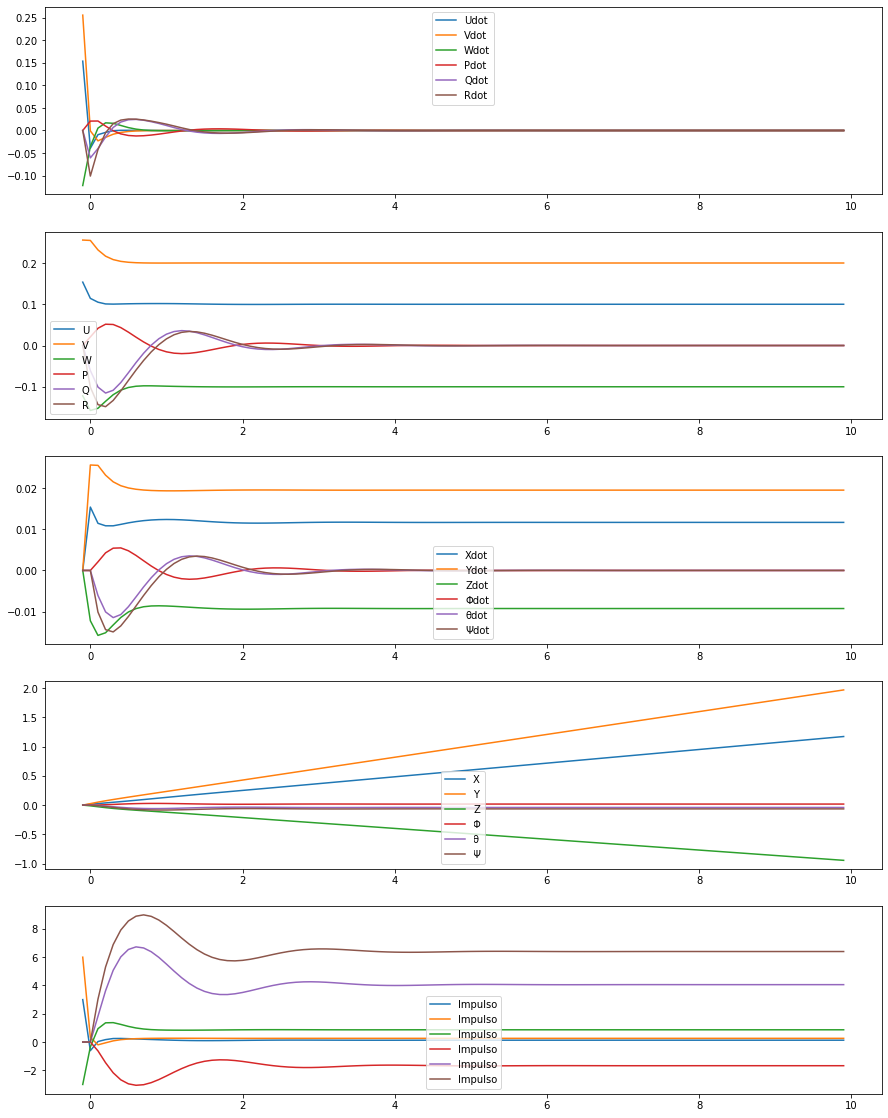

In [42]:
plt.figure(1, figsize = [15,20])

plt.subplot(511)
#plt.plot(t,u0,label='Impulso')
plt.plot(t,VdotValues.transpose()[0],label='Udot')
plt.plot(t,VdotValues.transpose()[1],label='Vdot')
plt.plot(t,VdotValues.transpose()[2],label='Wdot')
plt.plot(t,VdotValues.transpose()[3],label='Pdot')
plt.plot(t,VdotValues.transpose()[4],label='Qdot')
plt.plot(t,VdotValues.transpose()[5],label='Rdot')
plt.legend(loc='upper center')

plt.subplot(512)
#plt.plot(t,U1,label='Impulso')
plt.plot(t,VValues.transpose()[0],label='U')
plt.plot(t,VValues.transpose()[1],label='V')
plt.plot(t,VValues.transpose()[2],label='W')
plt.plot(t,VValues.transpose()[3],label='P')
plt.plot(t,VValues.transpose()[4],label='Q')
plt.plot(t,VValues.transpose()[5],label='R')
plt.legend(loc='lower left')


plt.subplot(513)
#plt.plot(t,u0,label='Impulso')
plt.plot(t,ndotValues.transpose()[0],label='Xdot')
plt.plot(t,ndotValues.transpose()[1],label='Ydot')
plt.plot(t,ndotValues.transpose()[2],label='Zdot')
plt.plot(t,ndotValues.transpose()[3],label='Φdot')
plt.plot(t,ndotValues.transpose()[4],label='θdot')
plt.plot(t,ndotValues.transpose()[5],label='Ψdot')
plt.legend(loc='lower center')

plt.subplot(514)
#plt.plot(t,u0,label='Impulso')
plt.plot(t,nValues.transpose()[0],label='X')
plt.plot(t,nValues.transpose()[1],label='Y')
plt.plot(t,nValues.transpose()[2],label='Z')
plt.plot(t,nValues.transpose()[3],label='Φ')
plt.plot(t,nValues.transpose()[4],label='θ')
plt.plot(t,nValues.transpose()[5],label='Ψ')
plt.legend(loc='lower center')

plt.subplot(515)
plt.plot(t,VectorerrorV,label='Impulso')
plt.legend(loc='lower center')

In [ ]:
Solve = []
Solve.append(Vdott["CMas"][0].subs([(u, 0), (x, 0.0), (u1, u1), (v, 0), (y, 0.0), (u2, u2), (w, 0), (z, 0.0), (u3, u3), (p, 0), (phi, 0.0), (u4, u4), (q, 0), (theta, 0.0), (u5, u5), (r, 0.1), (psi, 0.0), (u6, u6)]))
Solve.append(Vdott["CMas"][1].subs([(u, 0), (x, 0.0), (u1, u1), (v, 0), (y, 0.0), (u2, u2), (w, 0), (z, 0.0), (u3, u3), (p, 0), (phi, 0.0), (u4, u4), (q, 0), (theta, 0.0), (u5, u5), (r, 0.1), (psi, 0.0), (u6, u6)]))
Solve.append(Vdott["CMas"][2].subs([(u, 0), (x, 0.0), (u1, u1), (v, 0), (y, 0.0), (u2, u2), (w, 0), (z, 0.0), (u3, u3), (p, 0), (phi, 0.0), (u4, u4), (q, 0), (theta, 0.0), (u5, u5), (r, 0.1), (psi, 0.0), (u6, u6)]))
Solve.append(Vdott["CMas"][3].subs([(u, 0), (x, 0.0), (u1, u1), (v, 0), (y, 0.0), (u2, u2), (w, 0), (z, 0.0), (u3, u3), (p, 0), (phi, 0.0), (u4, u4), (q, 0), (theta, 0.0), (u5, u5), (r, 0.1), (psi, 0.0), (u6, u6)]))
Solve.append(Vdott["CMas"][4].subs([(u, 0), (x, 0.0), (u1, u1), (v, 0), (y, 0.0), (u2, u2), (w, 0), (z, 0.0), (u3, u3), (p, 0), (phi, 0.0), (u4, u4), (q, 0), (theta, 0.0), (u5, u5), (r, 0.1), (psi, 0.0), (u6, u6)]))
Solve.append(Vdott["CMas"][5].subs([(u, 0), (x, 0.0), (u1, u1), (v, 0), (y, 0.0), (u2, u2), (w, 0), (z, 0.0), (u3, u3), (p, 0), (phi, 0.0), (u4, u4), (q, 0), (theta, 0.0), (u5, u5), (r, 0.1), (psi, 0.0), (u6, u6)]))

Solve = np.array(Solve) + np.array([0,0,+ 0.304844606946984,0,0,0])
print(Solve.tolist())


In [ ]:
from sympy import *
linsolve(Solve.tolist(), [u1,u2,u3,u4,u5,u6])

In [ ]:
[(-1.70804059328649)*q*w + 1.56206088992974*r*v - u*(1.4192037470726*Abs(u) + 0.314597970335675) + 1.88134270101483e-5*u4 + 1.88134270101483e-5*u5 + 0.520686963309914*sin(theta), 1.09345327336332*p*w - 0.640179910044978*r*u + 1.2143928035982e-5*u6 - v*(1.08245877061469*Abs(v) + 0.310844577711144) - 0.333333333333333*sin(phi)*cos(theta), (-0.914533820840951)*p*v + 0.585466179159049*q*u - 1.52193784277879e-5*u1 - 1.52193784277879e-5*u2 - 1.02376599634369e-5*u3 - w*(1.69058500914077*Abs(w) + 0.236745886654479) - 0.304844606946984*cos(phi)*cos(theta), (-p)*(5.53571428571429*Abs(p) + 0.25) + 1.32010714285714e-7*u1 - 1.32010714285714e-7*u2 - 8.24464285714286e-8*u6 - 6.67857142857143*v*w + 0.0531864285714286*sin(phi)*cos(theta), (-q)*(5.53571428571429*Abs(q) + 0.25) + 32.3928571428571*u*w + 1.81960714285714e-7*u1 + 1.81960714285714e-7*u2 - 1.592e-7*u3 - 1.205e-8*u4 - 1.205e-8*u5 + 0.0531864285714286*sin(theta), (-r)*(5.53571428571429*Abs(r) + 0.25) - 25.7142857142857*u*v - 9.55392857142857e-8*u4 + 9.55392857142857e-8*u5 + 6.94285714285714e-9*u6]     ==      [-1.70804059328649*q*w + 1.56206088992974*r*v - u*(1.4192037470726*Abs(u) + 0.314597970335675) + 1.88134270101483e-5*u4 + 1.88134270101483e-5*u5 + 0.520686963309914*sin(theta), 1.09345327336332*p*w - 0.640179910044978*r*u + 1.2143928035982e-5*u6 - v*(1.08245877061469*Abs(v) + 0.310844577711144) - 0.333333333333333*sin(phi)*cos(theta), -0.914533820840951*p*v + 0.585466179159049*q*u - 1.52193784277879e-5*u1 - 1.52193784277879e-5*u2 - 1.02376599634369e-5*u3 - w*(1.69058500914077*Abs(w) + 0.236745886654479) - 0.304844606946984*cos(phi)*cos(theta), -p*(5.53571428571429*Abs(p) + 0.25) + 1.32010714285714e-7*u1 - 1.32010714285714e-7*u2 - 8.24464285714286e-8*u6 - 6.67857142857143*v*w + 0.0531864285714286*sin(phi)*cos(theta), -q*(5.53571428571429*Abs(q) + 0.25) + 32.3928571428571*u*w + 1.81960714285714e-7*u1 + 1.81960714285714e-7*u2 - 1.592e-7*u3 - 1.205e-8*u4 - 1.205e-8*u5 + 0.0531864285714286*sin(theta), -r*(5.53571428571429*Abs(r) + 0.25) - 25.7142857142857*u*v - 9.55392857142857e-8*u4 + 9.55392857142857e-8*u5 + 6.94285714285714e-9*u6] 

In [ ]:
[u*cos(psi)*cos(theta) + v*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + w*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)), u*sin(psi)*cos(theta) + v*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + w*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)), -u*sin(theta) + v*sin(phi)*cos(theta) + w*cos(phi)*cos(theta), 1.0*p + q*sin(phi)*sin(theta)/cos(theta) + r*sin(theta)*cos(phi)/cos(theta), q*cos(phi) - r*sin(phi), q*sin(phi)/cos(theta) + 1.0*r]     ==   [u*cos(psi)*cos(theta) + v*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + w*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)), u*sin(psi)*cos(theta) + v*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + w*((-sin(phi))*cos(psi) + sin(psi)*sin(theta)*cos(phi)), (-u)*sin(theta) + v*sin(phi)*cos(theta) + w*cos(phi)*cos(theta), 1.0*p + q*sin(phi)*sin(theta)/cos(theta) + r*sin(theta)*cos(phi)/cos(theta), q*cos(phi) - r*sin(phi), q*sin(phi)/cos(theta) + 1.0*r]

In [31]:
ResolvEcuations(Vdott,ndott,V,n,U,np.array([1,1,1,1,1,1]),np.array([1,1,1,1,1,1]),np.array([0,0,0,0,0,0]),dt)

[array([-0.14416384, -0.10915796, -0.23453908, -1.24401046,  2.66518977,
        -3.15      ]),
 array([ 0.11735727,  0.12703235, -0.00948957,  0.31519844, -0.03011687,
         0.25574077])]

In [ ]:
Vdott["CMas"]

In [36]:
np.dot(MTrans,np.array([1,1,1,1,1,1]))


array([ 406020.1405, -224607.1083, -299466.6953, -405660.3491,
        432880.2661,   35082.3045])